In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
caregivers_test1 = caregivers.loc[test1_subset]
tasks_test1 = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]

print(f"Number of caregivers in subset: {len(caregivers_test1)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test1)}")

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
caregivers_test2 = car_caregivers
tasks_test2 = tasks[tasks['PlannedCaregiverID'].isin(caregivers_test2.index)]

print(f"Number of caregivers in subset: {len(caregivers_test2)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test2)}")

Number of caregivers in subset: 3
Number of tasks assigned to subset caregivers: 27
Number of caregivers in subset: 17
Number of tasks assigned to subset caregivers: 160


In [3]:
from models.flexible_model import FlexibleModel
from models.fixed_model import FixedModel
model_type = FixedModel
model_caregivers = caregivers
model_tasks = tasks

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)
model.build()
model.optimize()

Set parameter Username
Set parameter LicenseID to value 2635249
Academic license - for non-commercial use only - expires 2026-03-11
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 11218 rows, 3644928 columns and 13083522 nonzeros
Model fingerprint: 0x73b545c0
Variable types: 21504 continuous, 3623424 integer (3623424 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 440 rows and 2210049 columns (presolve time = 5s)...
Presolve removed 440 rows and 2210049 columns
Presolve time: 9.63s
Presolved: 10778 rows, 1434879 columns, 4184938 nonzeros
Variable types: 0 continuous, 1434879 integer (1434815 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barr

<gurobi.Model MIP instance HomeCare: 11218 constrs, 3644928 vars, Parameter changes: Username=(user-defined), LicenseID=2635249>

/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:505: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


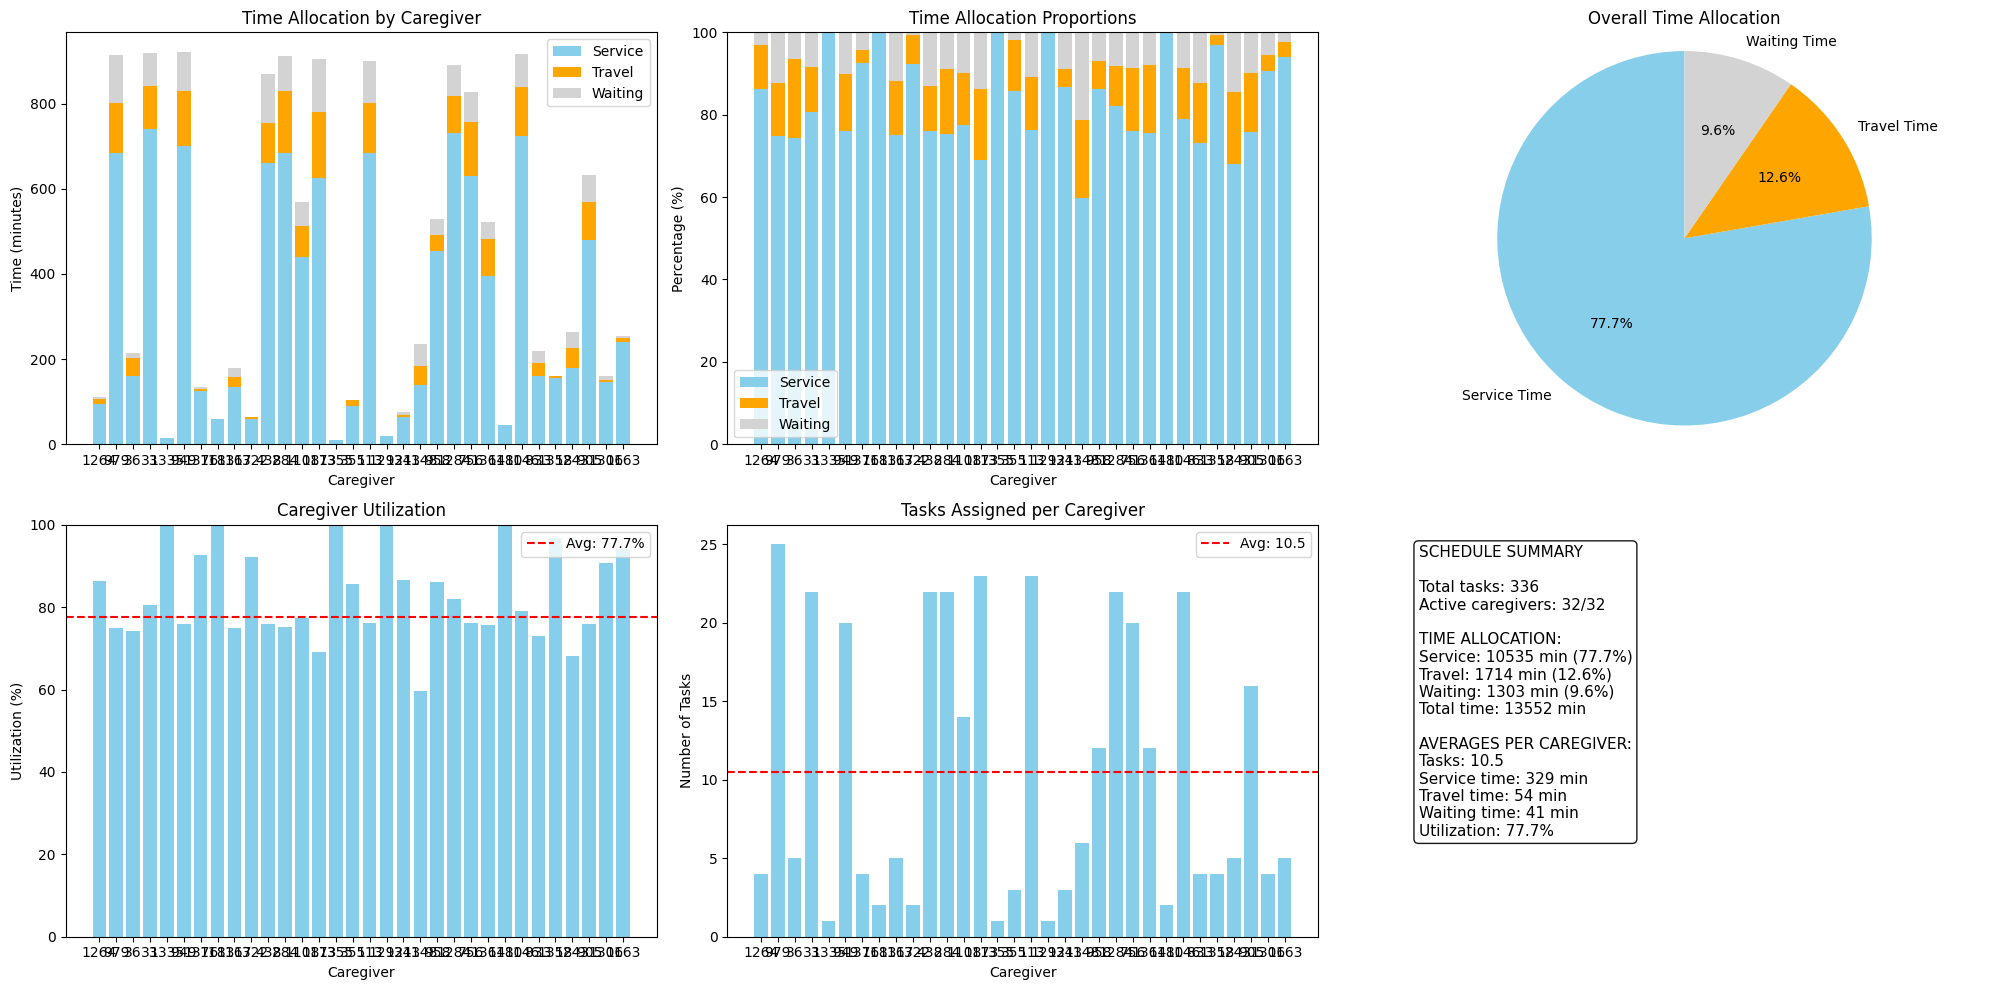

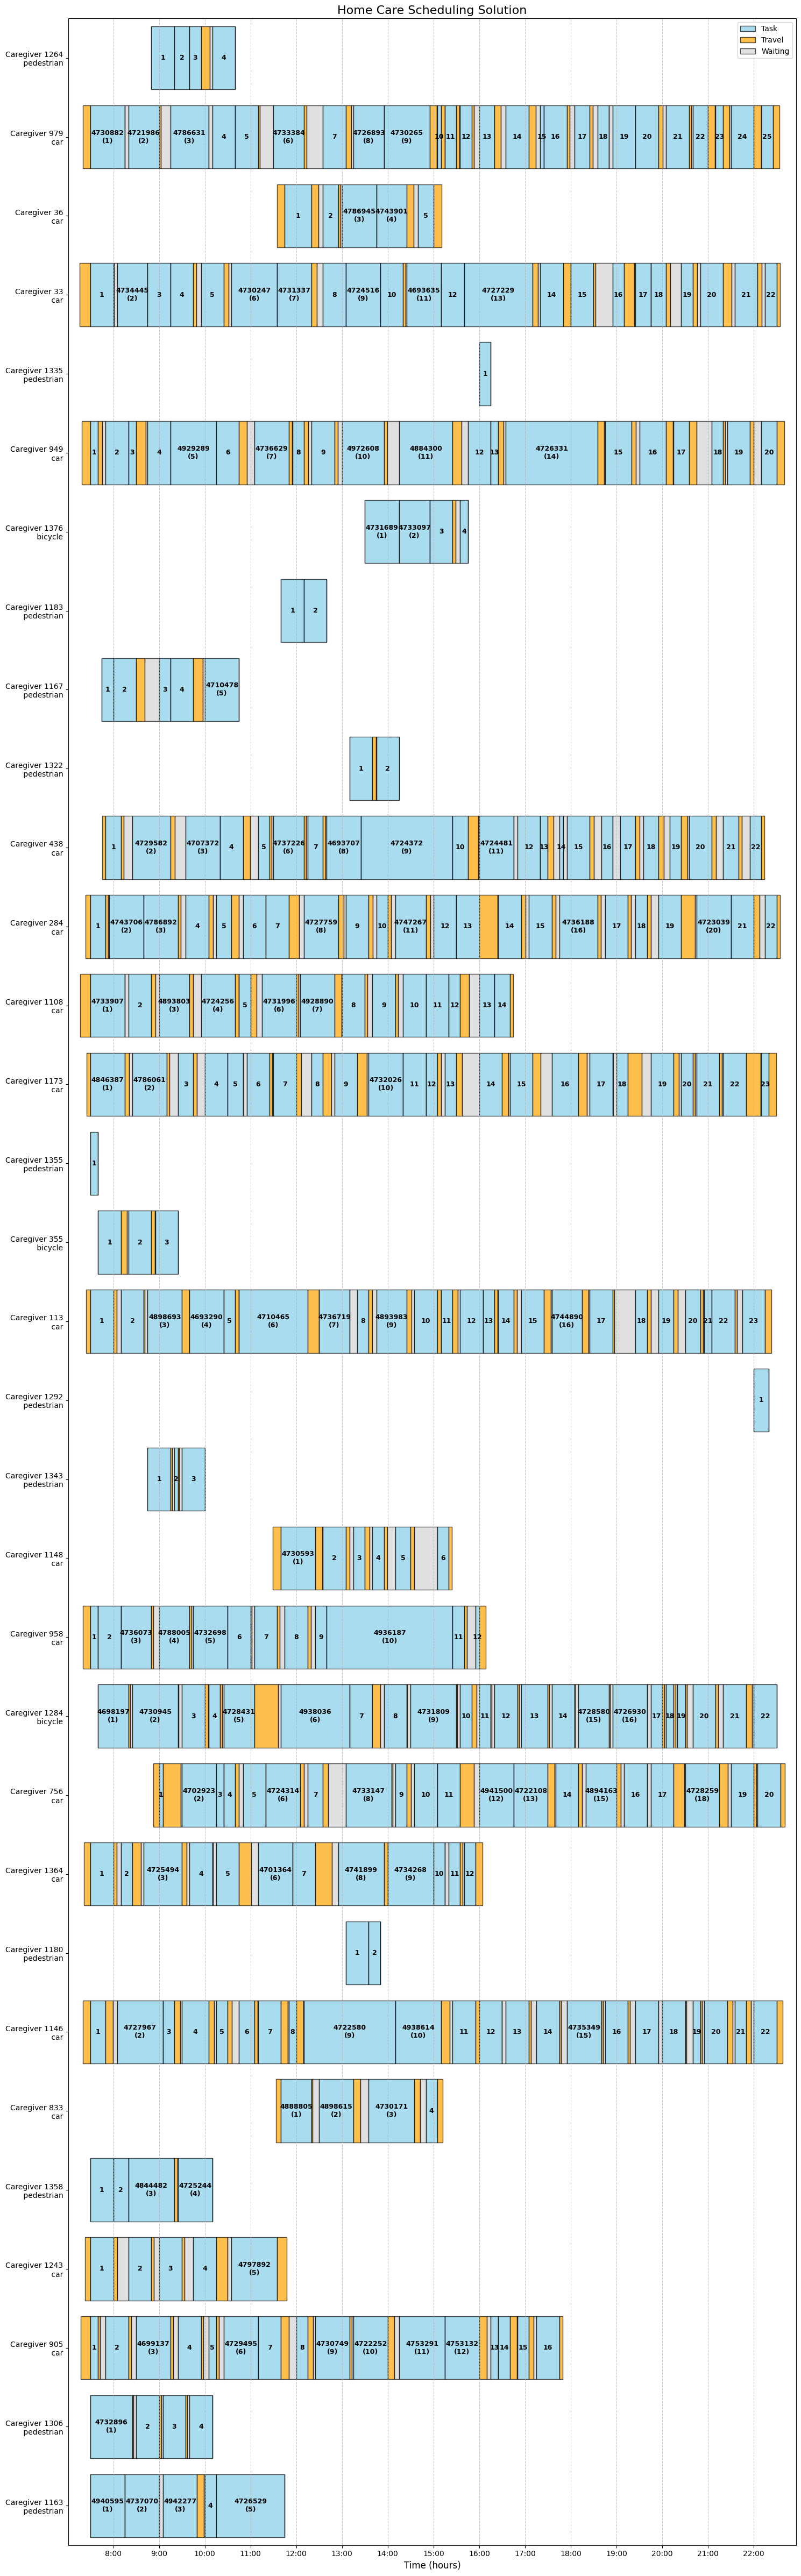

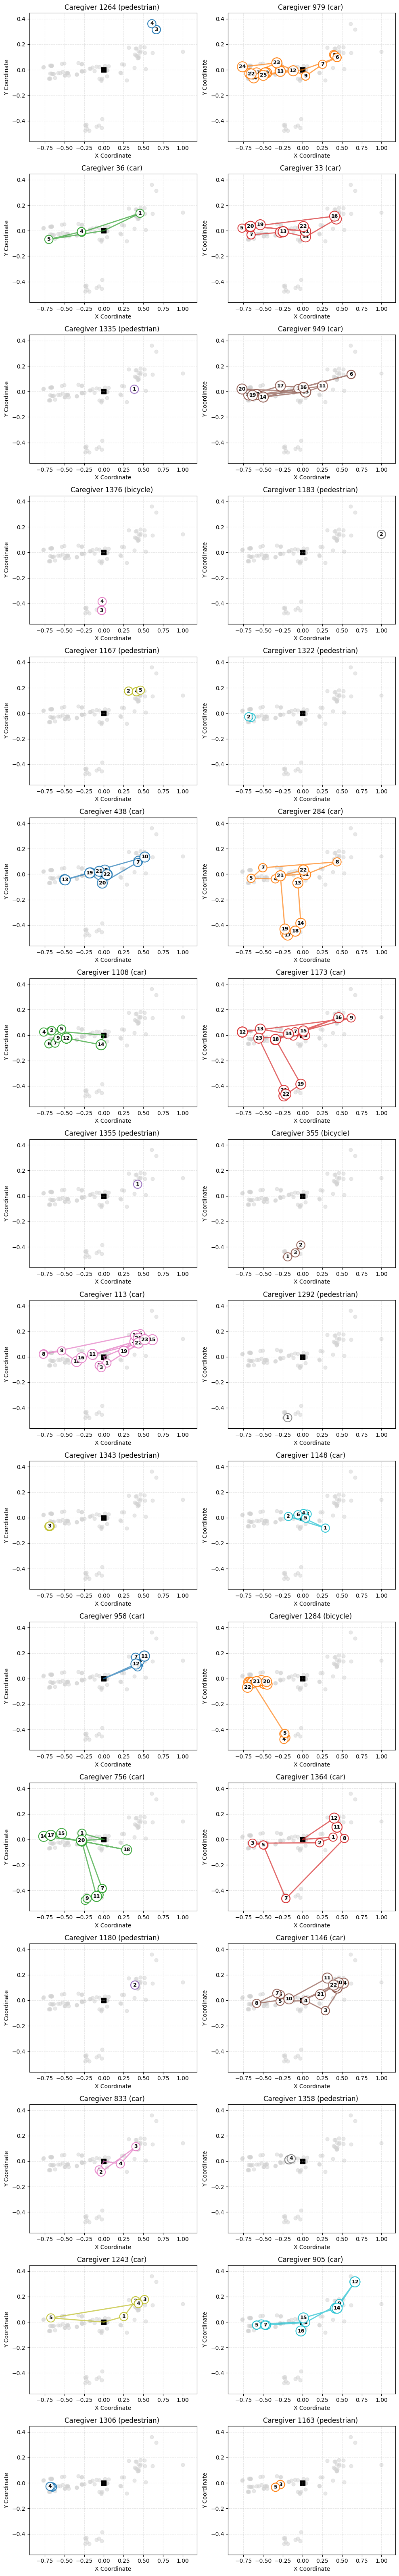

In [18]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes

model.get_solution()

visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);